In [54]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
import SimpleITK as sitk
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label, regionprops

from utils import myocardial_strain_zc
from scipy.ndimage import gaussian_filter
import DeepStrain.functions_collection as ff
import DeepStrain.Data_processing as Data_processing

main_path = '/mnt/mount_zc_NAS/Deepstrain'
data_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data'
spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_readmission_finalized.xlsx' ))

# Step 1: load a case (its segmentation and strain)

In [64]:
# find patinet_list
patient_list = spreadsheet.iloc[0:50]
patient_index = 4

In [66]:
# first: get the ED and ES frame
patient_id_num = patient_list['OurID'].iloc[patient_index]
patient_id = ff.XX_to_ID_00XX(patient_id_num)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES'].values[0].astype(int)
print(patient_id, ED,ES)

save_folder = os.path.join(main_path, 'results/strain/', patient_id)
ff.make_folder([save_folder])

# second: load img and seg
patient_img_folder = os.path.join(data_path, 'nii_img', patient_id)
patient_seg_folder = os.path.join(data_path, 'nii_manual_seg', patient_id)

V_nifti_ED = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ED) + '.nii.gz'))
V_nifti_ES = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ES) + '.nii.gz'))

M_nifti_ED = nb.load(os.path.join(patient_seg_folder, 'SAX_ED_seg.nii.gz'))
M_nifti_ES = nb.load(os.path.join(patient_seg_folder, 'SAX_ES_seg.nii.gz'))

M_nifti_ED_RV = nb.load(os.path.join(main_path,'results/fine_tune_carson/seg/' ,patient_id,'pred_seg_frame' + str(ED) + '.nii.gz'))
M_nifti_ES_RV = nb.load(os.path.join(main_path,'results/fine_tune_carson/seg/' ,patient_id,'pred_seg_frame' + str(ES) + '.nii.gz'))

# third: preprocess - change the label in segmentation: RV = 1, Myocardium = 2, LV = 3
M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
M_ED_RV = np.round(M_nifti_ED_RV.get_fdata()).astype(int)
new_M_ED = np.zeros_like(M_ED)
new_M_ED[M_ED_RV==3] = 1
new_M_ED[M_ED==1] = 3
new_M_ED[M_ED==2] = 2
M_nifti_ED = nb.Nifti1Image(new_M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

M_ES = np.round(M_nifti_ES.get_fdata()).astype(int)
M_ES_RV = np.round(M_nifti_ES_RV.get_fdata()).astype(int)
new_M_ES = np.zeros_like(M_ES)
new_M_ES[M_ES_RV==3] = 1
new_M_ES[M_ES==1] = 3
new_M_ES[M_ES==2] = 2
M_nifti_ES = nb.Nifti1Image(new_M_ES, affine=M_nifti_ES.affine, header=M_nifti_ES.header)

# fourth: prepare input
V_nifti = nb.funcs.concat_images((V_nifti_ED, V_nifti_ES))
M_nifti = nb.funcs.concat_images((M_nifti_ED, M_nifti_ES))

# data was trained with:
#  in-plane resolution of 1.25 mm x 1.25 mm
#  number of slices = 16
#  variable slice thickness since we specify number of slices
V_nifti = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
M_nifti = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)

# calculate center of mass using the first frame as reference. This is needed for cropping to 128x128
center = center_of_mass(M_nifti.get_fdata()[:,:,:,0]==2) # RV = 1, Myocardium = 2, LV = 3
V = _roll2center_crop(x=V_nifti.get_fdata(), center=center)
M = _roll2center_crop(x=M_nifti.get_fdata(), center=center)

# 
V = ff.normalize_image(V)
nx, ny, nz, nt = V.shape
V_0 =  np.repeat(V[:,:,:,:1], nt-1, axis=-1)
V_t =  V[:,:,:,1:]

V_0 = np.transpose(V_0, (3,0,1,2))
V_t = np.transpose(V_t, (3,0,1,2))

# fifth: predict motion vector
y_t = nb.load(os.path.join(main_path, 'results/trained/mvf', patient_id, 'mvf_ED_ES.nii.gz')).get_fdata()
y_t = y_t[None,...]
print('y_t shape: ', y_t.shape)

# smooth the motion fields. Note that these motion fields can be used to warp points individually, or could be 
# used to deform an endocardial contour. 
y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))

# last: calculate strain 
mask_end_diastole = M[..., 0]
mask_end_systole = M[..., 1]

# calculate strain
strain = myocardial_strain_zc.MyocardialStrain(mask=mask_end_diastole, flow=y_t[0,:,:,:,:])
strain.calculate_strain(lv_label=2)
strain_es = myocardial_strain_zc.MyocardialStrain(mask=mask_end_systole, flow=y_t[0,:,:,:,:])
strain_es.calculate_strain(lv_label=2)

print('Global Radial strain: ', 100*strain.Err[strain.mask_rot==2].mean())  # mask_rot means moves the whole mask (segmentation) to the center of myocardium
print('Global Circumferential strain: ', 100*strain.Ecc[strain.mask_rot==2].mean())

global_radial_strain = strain.Err[strain.mask_rot==2].mean()
global_circumferential_strain = strain.Ecc[strain.mask_rot==2].mean()
print('Global Radial strain: ', global_radial_strain) 
print('Global Circumferential strain: ', global_circumferential_strain)

ID_0685 1 8
y_t shape:  (1, 128, 128, 16, 3)
Global Radial strain:  20.128685005258667
Global Circumferential strain:  -14.923438405401305
Global Radial strain:  0.20128685005258667
Global Circumferential strain:  -0.14923438405401304


# Step 2: define the effective slice numbers

In [67]:
# define mid slice
# find the nonzero slices in the strain.mask
slice_nonzero_ed = [i for i in range(strain.mask.shape[2]) if np.sum(strain.mask[:,:,i] > 1)>0]
slice_nonzero_es = [i for i in range(strain_es.mask.shape[2]) if np.sum(strain_es.mask[:,:,i] > 1)>0]
slice_effective = slice_nonzero_es
print(strain.mask.shape, slice_nonzero_ed)
print(strain_es.mask.shape, slice_effective)

# find out it starts from apex or base
start_slice = np.copy(strain.mask[:,:,slice_nonzero_ed[1]]); start_slice[start_slice >0] = 1
end_slice = np.copy(strain.mask[:,:,slice_nonzero_ed[-1 - 2]]); end_slice[end_slice >0] = 1
if np.sum(start_slice) < np.sum(end_slice):
    start_slice_name = 'apex'
else:
    start_slice_name = 'base'
print('start from : ', start_slice_name)

(128, 128, 16) [6, 7, 8, 9, 10, 11, 12, 13, 14]
(128, 128, 16) [7, 8, 9, 10, 11, 12, 13, 14]
start from :  base


# Step 3: using the effective slice, define the strain in different layers

In [71]:
slices_per_layer = len(slice_effective)//3
mod = len(slice_effective)%3
if mod == 1 or mod == 2:
    mod = 1

if start_slice_name == 'apex':
    apex_layer = slice_effective[0 : slices_per_layer]
    mid_layer = slice_effective[slices_per_layer : slices_per_layer * 2 + mod]
    base_layer = slice_effective[slices_per_layer * 2 + mod: len(slice_effective)]
        
else: # start from "base"
    apex_layer = slice_effective[len(slice_effective) - slices_per_layer : len(slice_effective)]
    mid_layer = slice_effective[len(slice_effective) - slices_per_layer * 2 -mod : len(slice_effective) - slices_per_layer]
    base_layer = slice_effective[0: len(slice_effective) - slices_per_layer * 2 -mod]

print('base_layer: ', base_layer)
print('mid_layer: ', mid_layer)
print('apex_layer: ', apex_layer)


Err_copy = np.copy(strain.Err); layer_name = ['base', 'mid', 'apex']
Err_layer = []
for l in range(0,len([base_layer, mid_layer,apex_layer])):
    layer = [base_layer, mid_layer,apex_layer][l]

    err_copy = np.copy(Err_copy[:,:,layer])
   
    Err_layer.append(err_copy[strain.mask_rot[:,:,layer]==2].mean())

Ecc_copy = np.copy(strain.Ecc); layer_name = ['base', 'mid', 'apex']
Ecc_layer = []
for l in range(0,len([base_layer, mid_layer,apex_layer])):
    layer = [base_layer, mid_layer,apex_layer][l]
   
    ecc_copy = np.copy(Ecc_copy[:,:,layer])
   
    Ecc_layer.append(ecc_copy[strain.mask_rot[:,:,layer]==2].mean())

layer_radial_strain = np.asarray(Err_layer)
layer_circumferential_strain = np.asarray(Ecc_layer)
print('layer_radial_strain: ', layer_radial_strain)
print('layer_circumferential_strain: ', layer_circumferential_strain)



base_layer:  [7, 8, 9]
mid_layer:  [10, 11, 12]
apex_layer:  [13, 14]
layer_radial_strain:  [ 0.24902914  0.1963029  -0.07980562]
layer_circumferential_strain:  [-0.13892336 -0.14602031 -0.25096941]


# Step 4: define the RV insertion point (should be done in advance) and rotate the data accordingly

mid_slice:  10
phi_angle:  101.2682835701839


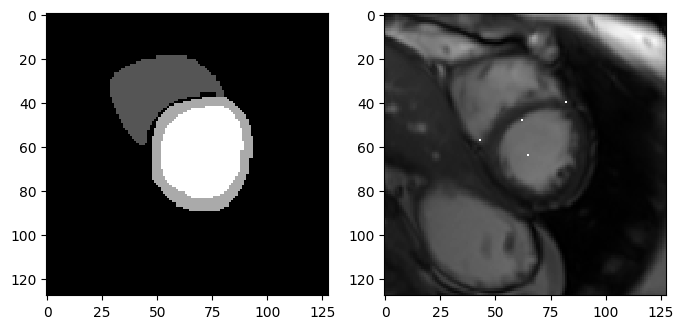

In [72]:
V_ed = V[:,:,:,0]

# define mid slice
mid_slice = slice_nonzero_ed[len(slice_nonzero_ed)//2]
print('mid_slice: ', mid_slice)


# define the RV insertion point
plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(strain.mask[:,:,mid_slice], cmap='gray')
if os.path.isfile(os.path.join(save_folder, 'insertion_points.npy')):
    insertion_points = np.load(os.path.join(save_folder, 'insertion_points.npy'))
    insertion_p1 = insertion_points[0,:]
    insertion_p2 = insertion_points[1,:]
else:
    print('no there should be pre-defined insertion points!')
    # from the figure, we define the RV insertion points
    # insertion_p1 = [73,87]
    # insertion_p2 = [40,65]
    # # make insertion_p1 and p2 as a 2x2 numpy array
    # insertion_points = np.vstack((np.asarray(insertion_p1), np.asarray(insertion_p2)))
    # # save the insertion points
    # np.save(os.path.join(save_folder, 'insertion_points.npy'), insertion_points)

# get the rotation angle ready
phi_angle   , cx_lv, cy_lv, cx_rv, cy_rv  = myocardial_strain_zc._get_lv2rv_angle_using_insertion_points(strain.mask, insertion_p1, insertion_p2)
print('phi_angle: ', phi_angle)

# plot
ii = np.copy(V_ed[:,:,mid_slice])
ii[insertion_p1[0], insertion_p1[1]] = np.max(ii); ii[insertion_p2[0], insertion_p2[1]] = np.max(ii)
ii[int(cx_lv), int(cy_lv)] = np.max(ii); ii[int(cx_rv), int(cy_rv)] = np.max(ii)
plt.subplot(122); plt.imshow(ii, cmap='gray')


[7, 8, 9, 10, 11, 12, 13, 14]


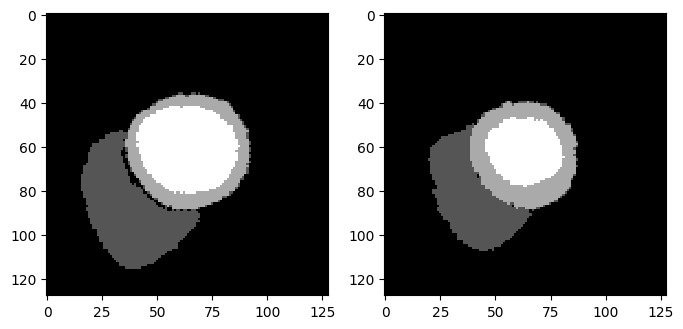

In [73]:
# rotate the data so that RV is under LV
rotate_f = myocardial_strain_zc.Rotate_data(strain.Err, strain.Ecc, strain.mask, insertion_p1, insertion_p2, non_slice_num = slice_effective )
Err_rot, Ecc_rot, mask_rot, ID = rotate_f.rotate_orientation(for_visualization=False)
Err_rot_vis, Ecc_rot_vis, mask_rot_vis, ID = rotate_f.rotate_orientation(for_visualization=True)

rotate_f_es = myocardial_strain_zc.Rotate_data(strain.Err, strain.Ecc, strain_es.mask, insertion_p1, insertion_p2, non_slice_num = slice_effective )
Err_rot_es, Ecc_rot_es, mask_rot_es, ID = rotate_f_es.rotate_orientation(for_visualization=False)

print(ID)
plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(mask_rot[:,:,1], cmap='gray')
plt.subplot(122); plt.imshow(mask_rot_es[:,:,1], cmap='gray')

# Step 5: Strain calculation and Polar Sampling

In [74]:
polar = myocardial_strain_zc.PolarMap(Err_rot, Ecc_rot, mask_rot)
polar_strain_result = polar.project_to_aha_polar_map()
Ecc_polar, Ecc_aha = polar.construct_AHA_map(polar_strain_result['V_ecc'], start_slice_name = start_slice_name, start = 20, stop = 80) 
# Ecc_aha first element is the mean for all AHA segments, followed by 16 segments + 1 apex (Set to 0)
Err_polar, Err_aha = polar.construct_AHA_map(polar_strain_result['V_err'], start_slice_name = start_slice_name, start = 20, stop = 80)

... radial strain
... circumferential strain


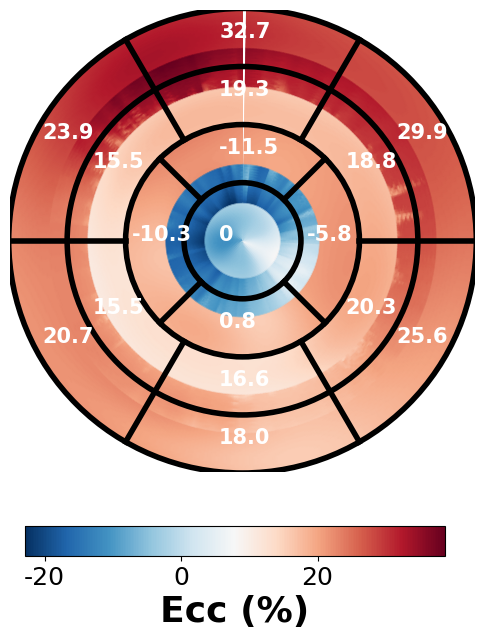

In [75]:
myocardial_strain_zc.plot_bullseye(Err_polar,Err_aha[1:],vmin=None,vmax=None, savepath=None,cmap='RdBu_r', label='Ecc (%)', 
                  std=None,cbar=True,color='white', fs=15, xshift=0, yshift=0, ptype='mesh',frac=False)

# Step 6: caculate wall thickness change index and polar sampling

In [76]:
# find out which slices need to use wall thickness change index
need_recal_slice_num = []
for j in range(strain.Err.shape[-1]):
    a = strain.Err[:,:,j]
    a = a[strain.mask_rot[:,:,j]==2] * 100
    if np.mean(a)<1:
        print('this slice needs to use segmentation of Err: ', j)
        need_recal_slice_num.append(j)

# find out the index of j in ID:
need_recal_slice_index = [ID.index(uu)  if uu in ID else None for uu in need_recal_slice_num]
print(need_recal_slice_index)

this slice needs to use segmentation of Err:  13
this slice needs to use segmentation of Err:  14
[6, 7, None]


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [77]:
wall_thickness = myocardial_strain_zc.wall_thickness_change_index(mask_rot, mask_rot_es)
wtci = wall_thickness.calculate_index()
wtci_polar, wtci_aha = wall_thickness.construct_AHA_map(wtci, start_slice_name = start_slice_name)

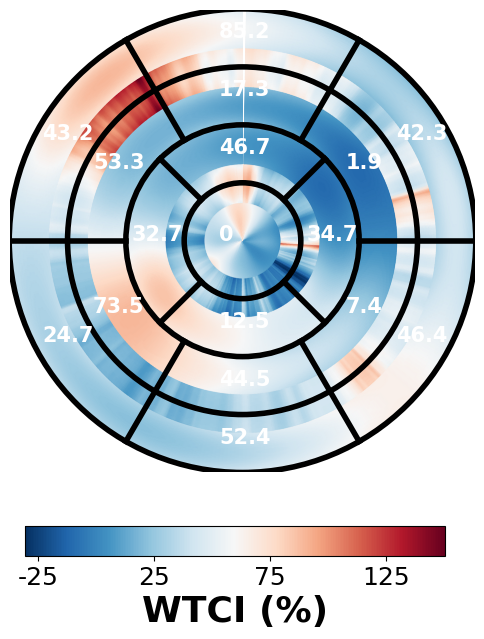

In [78]:
myocardial_strain_zc.plot_bullseye(wtci_polar, wtci_aha[1:],vmin=None,vmax=None, savepath=None,cmap='RdBu_r', label='WTCI (%)', 
                  std=None,cbar=True,color='white', fs=15, xshift=0, yshift=0, ptype='mesh',frac=False)

# collect all the parameters and save into numpy

In [82]:
raw_strain = [strain]
slice_info = [slice_nonzero_ed, slice_effective, start_slice_name, base_layer, mid_layer, apex_layer]
global_strain =   [global_radial_strain, global_circumferential_strain]
layer_strain = [  layer_radial_strain, layer_circumferential_strain]
rotated_mask = [ mask_rot, mask_rot_es,  mask_rot_vis]
polar_strain = [Err_rot, Ecc_rot, Err_rot_vis, Ecc_rot_vis, Ecc_polar, Ecc_aha[1:], Err_polar, Err_aha[1:]]
wtci_collect = [need_recal_slice_index, wtci, wtci_polar, wtci_aha[1:]]

# save all above
np.save(os.path.join(save_folder, 'raw_strain.npy'), np.asarray(raw_strain))
np.save(os.path.join(save_folder, 'slice_info.npy'), np.asarray(slice_info))
np.save(os.path.join(save_folder, 'global_strain.npy'), np.asarray(global_strain))
np.save(os.path.join(save_folder, 'layer_strain.npy'), np.asarray(layer_strain))
np.save(os.path.join(save_folder, 'rotated_mask.npy'), np.asarray(rotated_mask))
np.save(os.path.join(save_folder, 'polar_strain.npy'), np.asarray(polar_strain))
np.save(os.path.join(save_folder, 'wtci.npy'), np.asarray(wtci_collect))

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
